In [2]:
import os

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [5]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    
    def choose(self): return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [6]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

2022-01-03 21:46:46.223 | INFO     | torch_snippets.paths:inner:24 - 367 files found at dataset1/images_prepped_train
2022-01-03 21:46:46.231 | INFO     | torch_snippets.paths:inner:24 - 8 files found at dataset1/images_prepped_test


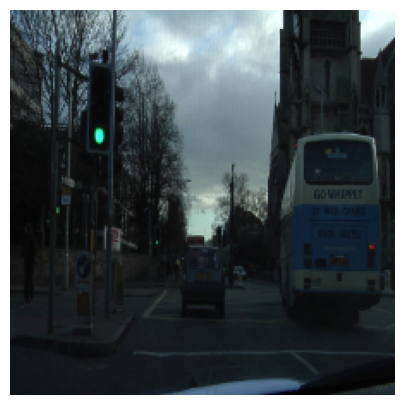

In [7]:
show(trn_ds[10][0])

In [8]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [9]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [10]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        x = self.conv11(x)

        return x

In [11]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [12]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [13]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [14]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.061	trn_acc: 0.758	val_loss: 0.817	val_acc: 0.772	(18.47s - 350.97s remaining)
EPOCH: 2.000	trn_loss: 0.681	trn_acc: 0.817	val_loss: 0.627	val_acc: 0.847	(33.01s - 297.08s remaining)
EPOCH: 3.000	trn_loss: 0.563	trn_acc: 0.848	val_loss: 0.644	val_acc: 0.836	(47.60s - 269.76s remaining)
EPOCH: 4.000	trn_loss: 0.513	trn_acc: 0.858	val_loss: 0.582	val_acc: 0.849	(62.30s - 249.18s remaining)
EPOCH: 5.000	trn_loss: 0.464	trn_acc: 0.871	val_loss: 0.517	val_acc: 0.853	(77.16s - 231.47s remaining)
EPOCH: 6.000	trn_loss: 0.457	trn_acc: 0.871	val_loss: 0.596	val_acc: 0.828	(92.04s - 214.77s remaining)
EPOCH: 7.000	trn_loss: 0.406	trn_acc: 0.885	val_loss: 0.523	val_acc: 0.842	(107.01s - 198.73s remaining)
EPOCH: 8.000	trn_loss: 0.378	trn_acc: 0.892	val_loss: 0.538	val_acc: 0.842	(122.04s - 183.06s remaining)
EPOCH: 9.000	trn_loss: 0.391	trn_acc: 0.886	val_loss: 0.491	val_acc: 0.856	(137.08s - 167.55s remaining)
EPOCH: 10.000	trn_loss: 0.354	trn_acc: 0.899	val_loss: 0.436	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1951.17it/s]


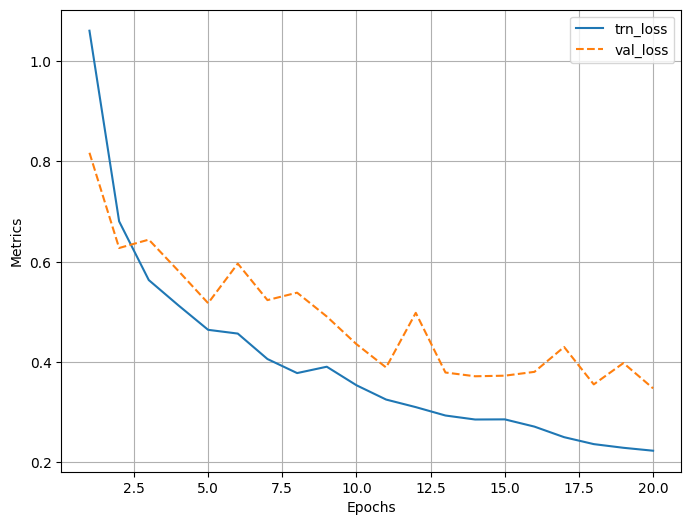

In [15]:
log.plot_epochs(['trn_loss','val_loss'])

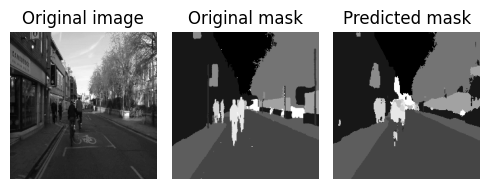

In [16]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])